In [1]:
import lake_model as lm
import pandas as pd

# OOP lake model

Still pretty rough...

## 1. Lake

The default is lake with an area of 0.2 km2, mean depth 5 m and residence time 0.7 years. Initial pH is 4.5, colour is 10 mgPt and the flow profile is `fjell`.

Alternatively, pass `kwargs` to the constructor to define a custom lake.

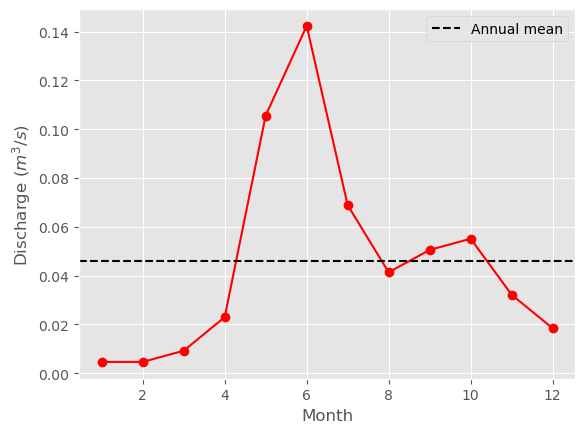

In [2]:
lake = lm.Lake()
lake.plot_flow_profile()

## 2. Lime product

Either specify the name of an existing product (defined in `lime_products.xlsx`), or set `from_database=False` and pass the required arguments to the constructor to create a custom product.

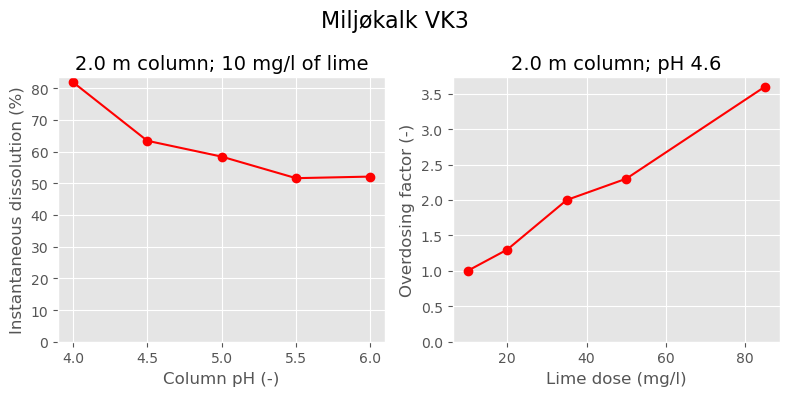

In [3]:
prod = lm.LimeProduct("Miljøkalk VK3")
prod.plot_column_data()

## 3. Model

Requires as input a lake object and a lime product object. 

By default, the lime dose is 10 mg/l, the liming month is 1, the spreading method is `wet`, the soluble fraction for lake-bottom lime is 0.4, the bottom dissolution coefficient is 1 and the number of months simulated is 24. This behaviour can be changed/overridden by passing kwargs to the constructor.

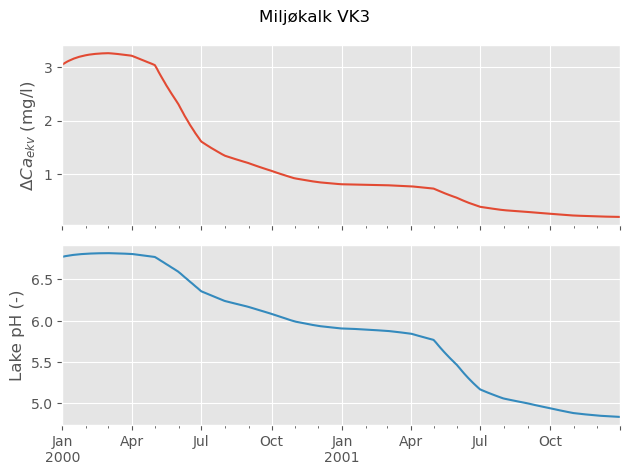

In [4]:
model = lm.Model(lake, prod)
model.plot_result()

## 4. Modify and re-run

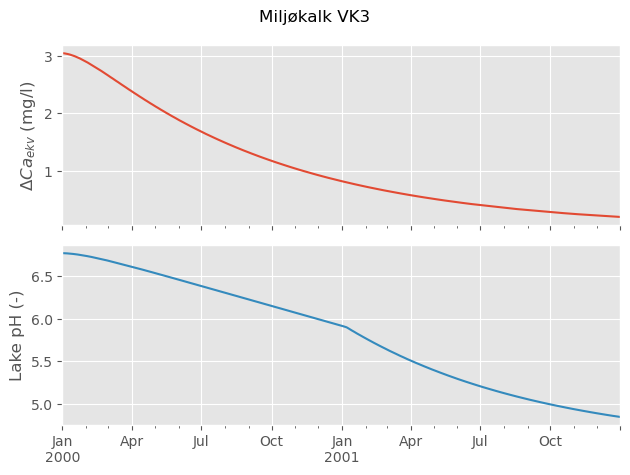

In [5]:
lake.flow_prof = "none"
model.plot_result()

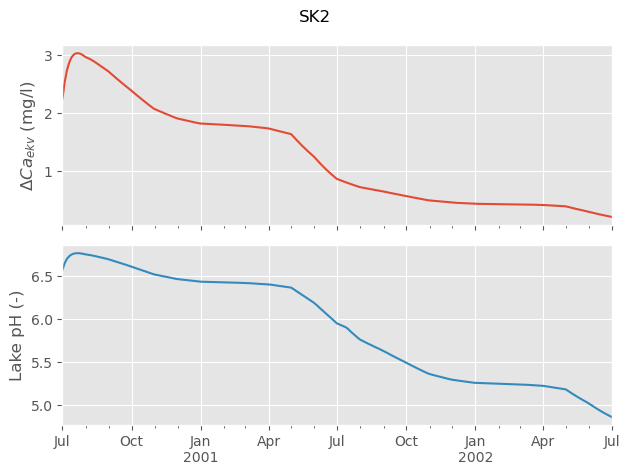

In [6]:
model.lime_month = 7
model.K_L = 3
model.F_sol = 1
model.lime_product = lm.LimeProduct("SK2")
lake.flow_prof = "fjell"
model.plot_result()